## Price Modeling

In [1]:
import pandas as pd
data  = pd.read_csv("Data handling/price.csv")

# Step 1: Convert 'Date' to datetime
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)
data = data[data['Date']<= '2020-04-29']

# Step 2: Set the date as index
data.set_index('Date', inplace=True)

# Step 3: Resample weekly and calculate mean
data = data.resample('W').mean(numeric_only=True)

print(data[['Primary Market','Secondary Market']].head())

            Primary Market  Secondary Market
Date                                        
2010-01-10           12.67           12.4625
2010-01-17           12.71           12.9620
2010-01-24           13.43           13.1940
2010-01-31           13.27           13.1340
2010-02-07           12.46           12.7980


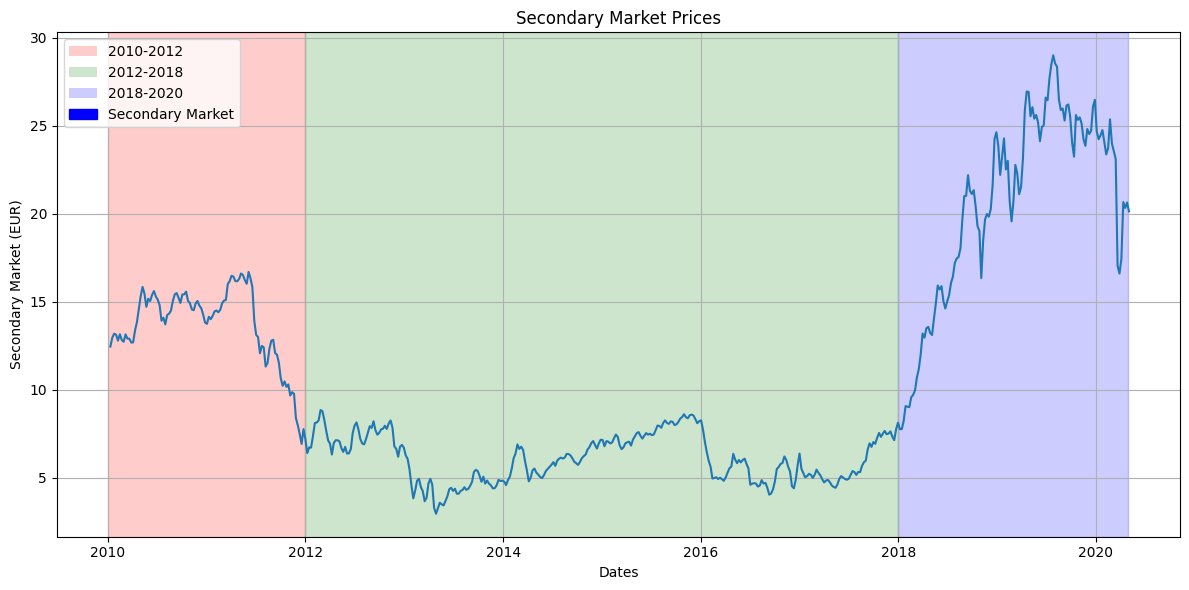

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

plt.figure(figsize=(12, 6))
ax = sns.lineplot(x=data.index, y=data['Secondary Market'], marker='', label='Secondary Market')
ax.axvspan(pd.Timestamp('2010-01-01'), pd.Timestamp('2011-12-31'), color='red', alpha=0.2)
ax.axvspan(pd.Timestamp('2012-01-01'), pd.Timestamp('2017-12-31'), color='green', alpha=0.2)
ax.axvspan(pd.Timestamp('2018-01-01'), pd.Timestamp('2020-04-29'), color='blue', alpha=0.2)
legend_elements = [Patch(facecolor='red', alpha=0.2, label='2010-2012'),
                   Patch(facecolor='green', alpha=0.2, label='2012-2018'),
                   Patch(facecolor='blue', alpha=0.2, label='2018-2020'),
                   Patch(linestyle='-', color='blue', label='Secondary Market')]
ax.legend(handles=legend_elements, loc='upper left')
plt.title('Secondary Market Prices')
plt.xlabel('Dates')
plt.ylabel('Secondary Market (EUR)')
plt.grid(True)
plt.tight_layout()
sns.set_context("notebook", font_scale=1.5)
plt.show()

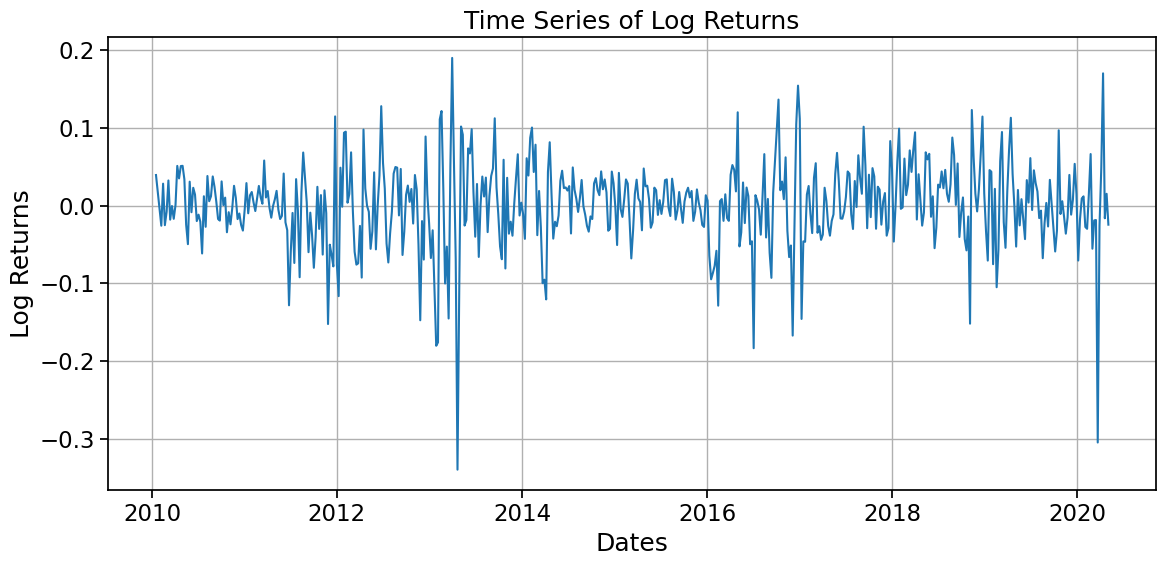

In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
data['returns'] = (np.log(data['Secondary Market']).diff())

plt.figure(figsize=(12, 6))

sns.lineplot(x=data.index, y=data.returns, marker='')

plt.title('Time Series of Log Returns')
plt.xlabel('Dates')
plt.ylabel('Log Returns')

sns.set_context("notebook", font_scale=1.5)

plt.grid(True)
plt.tight_layout()
plt.show()

In [4]:
from statsmodels.tsa.stattools import adfuller

r = data['returns'][1:].dropna()

result_adf = adfuller(r)
print('ADF Statistic:', round(result_adf[0],2))
print('p-value:', result_adf[1])

if result_adf[1] < 0.05:
    print("The series is stationary in mean (reject H₀).")
else:
    print("The series is not stationary in mean (fail to reject H₀).")

ADF Statistic: -10.0
p-value: 1.846562886523589e-17
The series is stationary in mean (reject H₀).


In [5]:
from statsmodels.stats.diagnostic import het_arch

# lag=12 is common; adjust based on your data
arch_test = het_arch(r, nlags=12)

print("ARCH Test Statistic:", round(arch_test[0],2))
print("p-value:", arch_test[1])

if arch_test[1] < 0.05:
    print("ARCH effects are present — variance is not stationary (reject H₀).")
else:
    print("No ARCH effects — variance is likely stationary (fail to reject H₀).")


ARCH Test Statistic: 54.57
p-value: 2.1584689580388867e-07
ARCH effects are present — variance is not stationary (reject H₀).


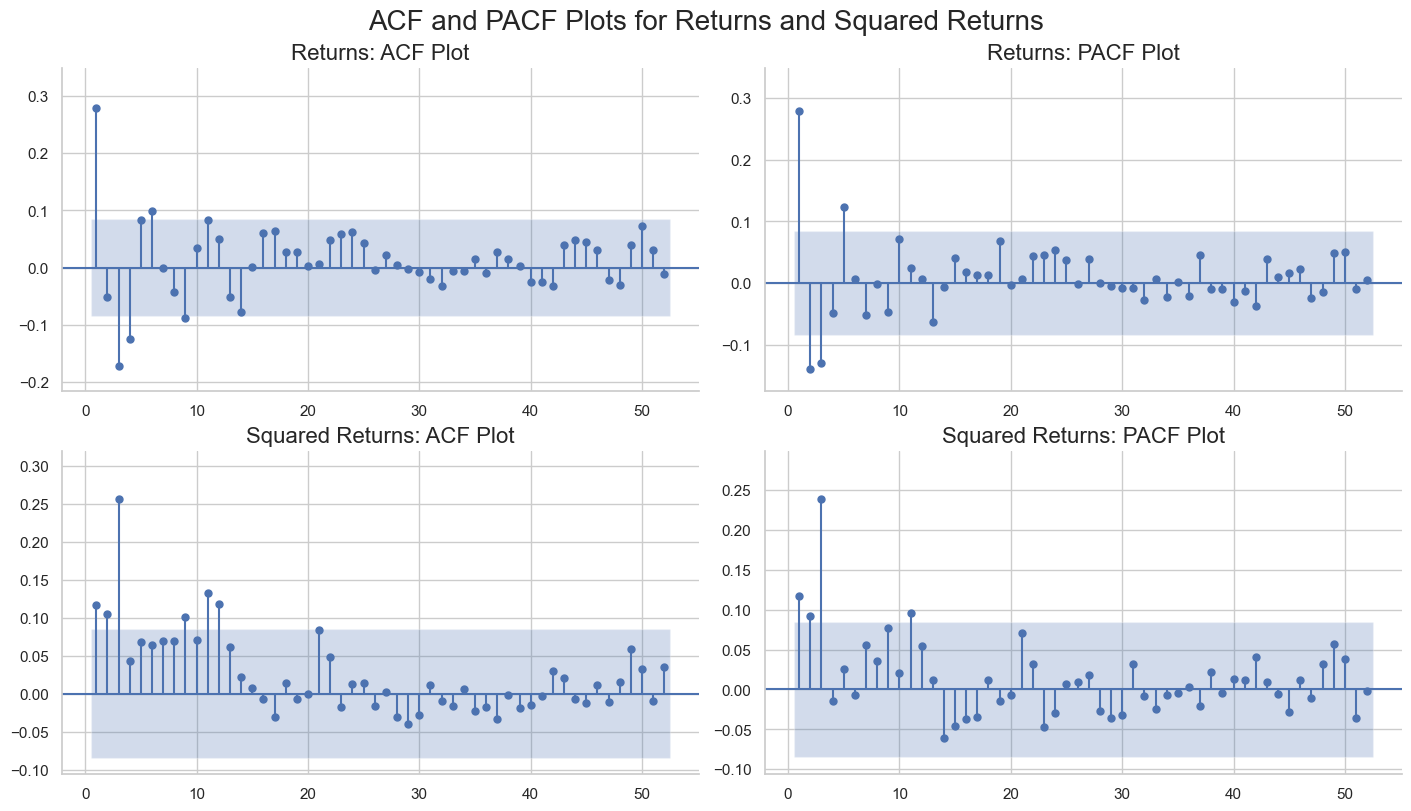

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Set seaborn theme
sns.set_theme(style="whitegrid")

# Create 2x2 subplot layout
fig, axes = plt.subplots(2, 2, figsize=(14, 8), constrained_layout=True)

# ACF of returns
plot_acf(r, lags=52, alpha=0.05, ax=axes[0, 0], use_vlines=True,
         zero=False, auto_ylims=True, bartlett_confint=False)
axes[0, 0].set_title("Returns: ACF Plot", fontsize=16)

# PACF of returns
plot_pacf(r, lags=52, alpha=0.05, ax=axes[0, 1], use_vlines=True,
          zero=False, auto_ylims=True)
axes[0, 1].set_title("Returns: PACF Plot", fontsize=16)

# ACF of squared returns
plot_acf(r**2, lags=52, alpha=0.05, ax=axes[1, 0], use_vlines=True,
         zero=False, auto_ylims=True, bartlett_confint=False)
axes[1, 0].set_title("Squared Returns: ACF Plot", fontsize=16)

# PACF of squared returns
plot_pacf(r**2, lags=52, alpha=0.05, ax=axes[1, 1], use_vlines=True,
          zero=False, auto_ylims=True)
axes[1, 1].set_title("Squared Returns: PACF Plot", fontsize=16)

# Apply Seaborn-style titles and layout
sns.despine()
plt.suptitle("ACF and PACF Plots for Returns and Squared Returns", fontsize=20)
plt.show()

In [16]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model

def rolling_forecast_ar3_garch11(returns, m_p = 3, m_q = 1, g_p = 1, g_q = 1, window_size=100, forecast_horizon=1):
    if isinstance(returns, np.ndarray):
        returns = pd.Series(returns)

    mean_forecasts = []
    actual_values = []
    variance_forecasts = []

    n = len(returns)

    print("-" * 60)

    for i in range(window_size, n - forecast_horizon + 1):
        window_data = returns.iloc[i - window_size:i]

        try:
            # Fit AR(3) model
            ar_model = ARIMA(window_data, order=(m_p, 0, m_q)).fit()
            mean_forecast = ar_model.forecast(steps=forecast_horizon)[0]

            # Residuals from AR(3) model
            residuals = ar_model.resid * 100  # scale up for GARCH
            # Fit GARCH(1,1) on residuals
            garch_model = arch_model(residuals, vol='Garch', p=g_p, q=g_q, rescale=False)
            garch_fitted = garch_model.fit(disp='off')
            garch_forecast = garch_fitted.forecast(horizon=1)
            variance_forecast = garch_forecast.variance.iloc[-1, 0]

            mean_forecasts.append(mean_forecast)
            variance_forecasts.append(variance_forecast)
            actual_values.append(returns.iloc[i + forecast_horizon - 1])

            if i % 20 == 0:
                print(f"Step {i - window_size + 1}: Mean forecast = {mean_forecast:.6f}, Var forecast = {variance_forecast:.6f}")
        
        except Exception as e:
            print(f"Error at step {i}: {e}")
            mean_forecasts.append(returns.iloc[i - 1])
            variance_forecasts.append(np.nan)
            actual_values.append(returns.iloc[i + forecast_horizon - 1])

    return np.array(mean_forecasts), np.array(actual_values), np.array(variance_forecasts)

forecasts, actuals, variances = rolling_forecast_ar3_garch11(r, window_size=104, forecast_horizon=1)

------------------------------------------------------------


c:\Users\chakr\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\chakr\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\chakr\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\chakr\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

Step 17: Mean forecast = 0.035749, Var forecast = 39.042113
Step 37: Mean forecast = -0.027840, Var forecast = 38.971130


c:\Users\chakr\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\chakr\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 57: Mean forecast = -0.072518, Var forecast = 46.122912


c:\Users\chakr\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\chakr\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\chakr\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\chakr\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

Step 77: Mean forecast = -0.046905, Var forecast = 63.049612


c:\Users\chakr\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 97: Mean forecast = -0.007666, Var forecast = 43.766595
Step 117: Mean forecast = -0.011855, Var forecast = 45.235291
Step 137: Mean forecast = 0.000409, Var forecast = 14.220217


c:\Users\chakr\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 157: Mean forecast = -0.016872, Var forecast = 7.033271


c:\Users\chakr\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\chakr\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\chakr\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\chakr\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

Step 177: Mean forecast = -0.005683, Var forecast = 9.457146


c:\Users\chakr\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\chakr\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\chakr\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\chakr\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

Step 197: Mean forecast = 0.011192, Var forecast = 4.520745


c:\Users\chakr\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\chakr\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\chakr\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\chakr\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

Step 217: Mean forecast = 0.008975, Var forecast = 18.633358


c:\Users\chakr\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\chakr\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\chakr\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\chakr\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

Step 237: Mean forecast = -0.018271, Var forecast = 50.625861


c:\Users\chakr\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\chakr\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\chakr\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\chakr\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

Step 257: Mean forecast = -0.064591, Var forecast = 51.746780


c:\Users\chakr\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\chakr\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\chakr\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\chakr\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

Step 277: Mean forecast = -0.014640, Var forecast = 21.943599


c:\Users\chakr\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 297: Mean forecast = 0.030666, Var forecast = 33.071889


c:\Users\chakr\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 317: Mean forecast = 0.027751, Var forecast = 18.476376


c:\Users\chakr\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\chakr\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 337: Mean forecast = -0.013716, Var forecast = 15.747188


c:\Users\chakr\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\chakr\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\chakr\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\chakr\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

Step 357: Mean forecast = -0.042577, Var forecast = 38.461233


c:\Users\chakr\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\chakr\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\chakr\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\chakr\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

Step 377: Mean forecast = 0.009099, Var forecast = 31.792250
Step 397: Mean forecast = 0.016653, Var forecast = 17.217537


c:\Users\chakr\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 417: Mean forecast = 0.009367, Var forecast = 17.969654


c:\Users\chakr\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def evaluate_forecasts(forecasts, actual_values, variance_forecasts=None):
    """
    Evaluate forecast performance using standard metrics.
    
    Parameters:
    - forecasts: array-like of forecasted values
    - actual_values: array-like of true values
    - variance_forecasts: optional array-like of conditional variances (from GARCH)

    Returns:
    - Dictionary of evaluation metrics
    """
    forecasts = np.array(forecasts)
    actuals = np.array(actual_values)

    if len(forecasts) == 0:
        print("No forecasts available.")
        return None

    # Handle missing values
    if variance_forecasts is not None:
        variance_forecasts = np.array(variance_forecasts)
        mask = ~(np.isnan(forecasts) | np.isnan(actuals) | np.isnan(variance_forecasts))
        variance_forecasts = variance_forecasts[mask]
    else:
        mask = ~(np.isnan(forecasts) | np.isnan(actuals))

    forecasts = forecasts[mask]
    actuals = actuals[mask]

    if len(forecasts) == 0:
        print("No valid forecasts available for evaluation.")
        return None

    # Compute metrics
    mse = mean_squared_error(actuals, forecasts)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, forecasts)

    # Direction accuracy
    actual_direction = np.sign(actuals)
    forecast_direction = np.sign(forecasts)
    direction_accuracy = np.mean(actual_direction == forecast_direction)

    # Hit rate: within 1 std from forecast (using GARCH variance if given)
    if variance_forecasts is not None:
        std_forecast = np.sqrt(variance_forecasts) / 100  # scaled down to original return scale
        hit_mask = np.abs(forecasts - actuals) <= std_forecast
        hit_rate = np.mean(hit_mask)
    else:
        std_actual = np.std(actuals)
        hit_rate = np.mean(np.abs(forecasts - actuals) <= std_actual)

    metrics = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'Direction Accuracy': direction_accuracy,
        'Hit Rate': hit_rate,
        'Number of Forecasts': len(forecasts)
    }

    print("\nForecast Evaluation Metrics:")
    print("-" * 30)
    for metric, value in metrics.items():
        if metric in ['Direction Accuracy', 'Hit Rate']:
            print(f"{metric}: {value:.4f} ({value * 100:.2f}%)")
        else:
            print(f"{metric}: {value:.6f}")

    return metrics

metrics = evaluate_forecasts(forecasts, actuals, variance_forecasts=variances)


Forecast Evaluation Metrics:
------------------------------
MSE: 0.003217
RMSE: 0.056720
MAE: 0.040993
Direction Accuracy: 0.5829 (58.29%)
Hit Rate: 0.7074 (70.74%)
Number of Forecasts: 434.000000


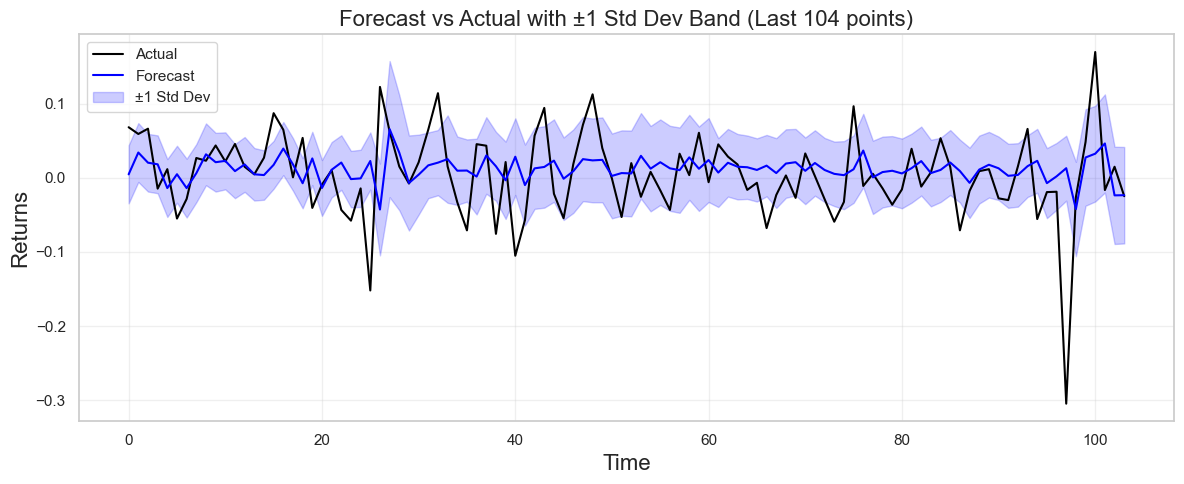

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_forecast_with_variance_band(forecasts, actual_values, variance_forecasts, last_n=104):
    """
    Plot forecast vs actual with ±1 std dev forecast bands using GARCH variance.

    Parameters:
    - forecasts: array-like, forecasted mean values
    - actual_values: array-like, actual observed values
    - variance_forecasts: array-like, forecasted variances (from GARCH)
    - last_n: number of recent observations to show in the plot
    """
    forecasts = np.array(forecasts)
    actuals = np.array(actual_values)
    variance_forecasts = np.array(variance_forecasts)

    # Use only the last_n observations
    n_plot = min(last_n, len(forecasts))
    forecasts = forecasts[-n_plot:]
    actuals = actuals[-n_plot:]
    std_dev = np.sqrt(variance_forecasts[-n_plot:]) / 100  # adjust if you scaled residuals *100

    upper_band = forecasts + std_dev
    lower_band = forecasts - std_dev

    plt.figure(figsize=(12, 5))
    plt.plot(actuals, label='Actual', color='black', linewidth=1.5)
    plt.plot(forecasts, label='Forecast', color='blue', linewidth=1.5)
    plt.fill_between(range(n_plot), lower_band, upper_band, color='blue', alpha=0.2, label='±1 Std Dev')

    plt.title(f'Forecast vs Actual with ±1 Std Dev Band (Last {n_plot} points)',fontsize = 16)
    plt.xlabel('Time',fontsize = 16)
    plt.ylabel('Returns',fontsize = 16)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_forecast_with_variance_band(forecasts, actuals, variances)

## Network

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np

data = pd.read_csv("Data handling/daily_country.csv")
# data = data.drop(data.columns[0],axis=1)
data = data.sort_values(by='acquiringAccount_registry')
# data['amount'] = round(data['amount']/10**9,2)
data.head()

,date,transferringAccount_registry,acquiringAccount_registry,Secondary_Market_price,amount
0,2010-01-05,Austria,Austria,12.55,15000.0
24373,2012-04-16,Austria,Austria,6.79,822.0
24400,2012-04-16,Netherlands,Austria,6.79,25000.0
24423,2012-04-17,Austria,Austria,7.05,25000.0
94339,2019-11-14,Netherlands,Austria,23.95,3000.0


In [2]:
# Ensure date column is datetime
data["date"] = pd.to_datetime(data["date"])

# Extract financial year (April to March)
# If month >= 4 (April onwards), FY = current year, else FY = previous year
data["year"] = data["date"].dt.year + (data["date"].dt.month >= 4).astype(int)
data['value'] = data['Secondary_Market_price'] * data['amount']

# Group by financial year + the 2 registry columns
yearly_agg = (
    data.groupby(["year", "transferringAccount_registry", "acquiringAccount_registry"], as_index=False)
      .agg({"value": "sum"})
)

yearly_agg.tail()

,year,transferringAccount_registry,acquiringAccount_registry,value
4149,2021,United Kingdom,Romania,1.414000e+07
4150,2021,United Kingdom,Slovakia,1.116860e+06
4151,2021,United Kingdom,Spain,1.264948e+07
4152,2021,United Kingdom,Sweden,2.984604e+05
4153,2021,United Kingdom,United Kingdom,5.362576e+08


In [3]:
yearly_agg['value'] = round(yearly_agg['value']/10**9,2)

In [11]:
import os
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

pos = {'Austria': np.array([-0.76474842, 0.28204283]),
       'Czech Republic': np.array([-0.23295827, -0.44086543]),
       'Belgium': np.array([-0.67474842, -0.1774826]),
       'Denmark': np.array([-0.5043414, 0.86124392]),
       'Estonia': np.array([-0.87921385, 0.54965594]),
       'Finland': np.array([-0.28897237, -0.93319228]),
       'France': np.array([0.96884621, -0.15476583]),
       'Germany': np.array([-0.40474968, 0.05111638]),
       'Greece': np.array([0.71556863, 0.57055307]),
       'Ireland': np.array([-0.54516766, -0.82519921]),
       'Italy': np.array([0.12703703, -1.]),
       'Netherlands': np.array([0.70581181, -0.70303436]),
       'Norway': np.array([-0.66474842, 0.50204283]),
       'Others': np.array([-0.73295827, -0.44086543]),
       'Poland': np.array([0.89898859, 0.42721634]),
       'Portugal': np.array([-0.19906405, 1.02254584]),
       'Romania': np.array([0.16985951, 0.67352962]),
       'Slovakia': np.array([0.5094843, 0.87899224]),
       'Spain': np.array([-0.15, 0.35]),
       'Sweden': np.array([-0.77474842, 0.03822761]),
       'United Kingdom': np.array([0.50116221, 0.26336382])}

def plot_trade_networks_global(data, pos, out_folder="trade_networks2"):
    os.makedirs(out_folder, exist_ok=True)
    valid_nodes = set(pos.keys())
    data = data[data['transferringAccount_registry'].isin(valid_nodes) & 
                data['acquiringAccount_registry'].isin(valid_nodes)]
    
    threshold = data['value'].quantile(0.95)
    vmin, vmax = data['value'].min(), data['value'].max()
    print(f"global threshold: {threshold}")
    
    newpos = {n: np.array([c[0], c[1] - 0.06]) for n, c in pos.items()}
    
    for year in sorted(data['year'].unique()):
        G = nx.DiGraph()
        G.add_nodes_from(valid_nodes)
        data_year = data[data['year'] == year]
        if data_year.empty:
            continue
        
        for _, row in data_year.iterrows():
            src, dst, val = row["transferringAccount_registry"], row["acquiringAccount_registry"], row["value"]
            if src != dst and val > threshold:
                G.add_edge(src, dst, weight=val)
            elif src == dst:
                G.nodes[src]["node_wt"] = val
        
        # Edge styling
        norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
        edge_colors = [cm.RdYlGn(norm(d['weight'])) for _, _, d in G.edges(data=True)] if G.number_of_edges() > 0 else []
        
        # Node styling
        node_wts = nx.get_node_attributes(G, 'node_wt')
        if node_wts:
            node_colors = [cm.Wistia(norm(node_wts.get(n, 0))) for n in G.nodes()]
            node_sizes = [5000 + 60000 * (node_wts.get(n, 0) / vmax) for n in G.nodes()]
        else:
            node_colors, node_sizes = "lightgray", 5000
        
        fig, ax = plt.subplots(figsize=(20, 12))
        nx.draw(G, pos, with_labels=True, arrows=True, node_color=node_colors, 
                node_size=node_sizes, font_size=20, width=2.5, arrowsize=30, 
                font_weight="bold", edge_color=edge_colors, connectionstyle='arc3,rad=-0.1')
        nx.draw_networkx_labels(G, newpos, labels=node_wts, font_size=15, font_weight="bold")
        nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'weight'),
                                     font_size=12, connectionstyle='arc3,rad=-0.1', 
                                     font_color='tomato', font_weight="bold")
        
        ax.set_title(f"Trade Network - {year} (Transferred Value in Billions of EUR)", 
                    fontdict={'fontsize': 25, 'fontweight': "bold"})
        plt.tight_layout()
        plt.savefig(os.path.join(out_folder, f"trade_network_{year}.png"))
        plt.close()
    
    print(f"Saved yearly trade network plots in {out_folder}/")

# Example usage:
plot_trade_networks_global(yearly_agg, pos, out_folder="trade_networks2")

global threshold: 0.7569999999999982
Saved yearly trade network plots in trade_networks2/


Computing eigenvector centrality for 33 countries...
✅ Centrality metrics saved: centralities_scaled/Austria_centralities.csv
✅ Centrality metrics saved: centralities_scaled/Belgium_centralities.csv
✅ Centrality metrics saved: centralities_scaled/Bulgaria_centralities.csv
⚠️ Croatia missing in year 2011, skipping.
⚠️ Croatia missing in year 2012, skipping.
⚠️ Croatia missing in year 2013, skipping.
✅ Centrality metrics saved: centralities_scaled/Croatia_centralities.csv
✅ Centrality metrics saved: centralities_scaled/Cyprus_centralities.csv
✅ Centrality metrics saved: centralities_scaled/Czech_Republic_centralities.csv
✅ Centrality metrics saved: centralities_scaled/Denmark_centralities.csv
✅ Centrality metrics saved: centralities_scaled/Estonia_centralities.csv
⚠️ European Commission missing in year 2011, skipping.
⚠️ European Commission missing in year 2012, skipping.
⚠️ European Commission missing in year 2013, skipping.
⚠️ European Commission missing in year 2016, skipping.
⚠️ Euro

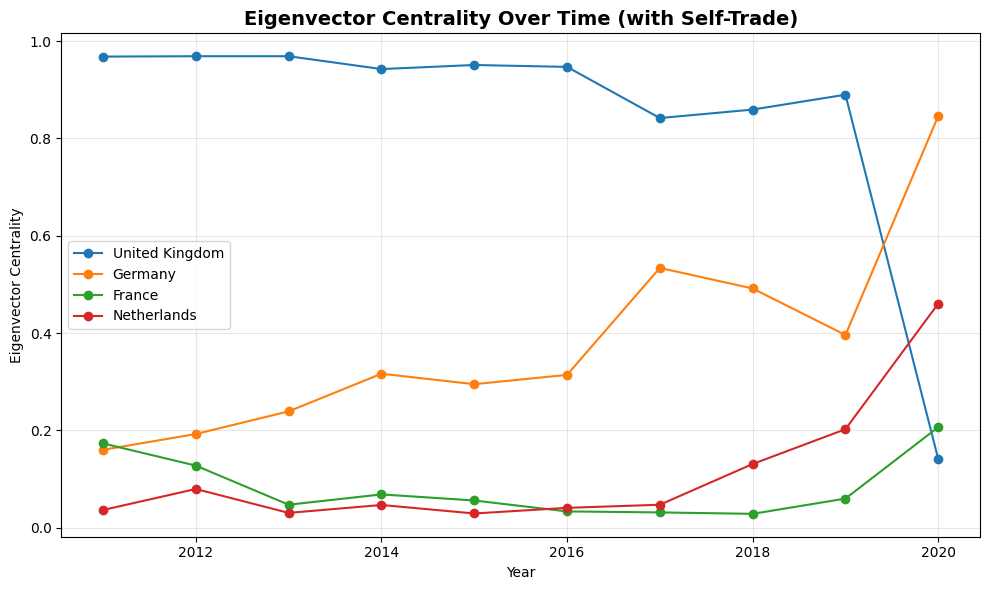

In [6]:
import os
import numpy as np
import pandas as pd
import networkx as nx


def compute_country_centralities(data, country_name, out_folder="centralities_scaled"):
    """
    Computes eigenvector centrality for a given country across all years.
    - Edge weights = trade volume between different countries
    - Self-loops = self-trade (node capacity)
    Both are incorporated into the adjacency matrix before computing centrality.
    """

    os.makedirs(out_folder, exist_ok=True)

    results = []  # store per-year results

    for year in sorted(data["year"].unique()):
        data_year = data[data["year"] == year]
        if data_year.empty or year in [2010, 2021]:
            continue

        # --- Build directed graph for that year ---
        G = nx.DiGraph()
        nodes = set(data_year["transferringAccount_registry"]).union(
            data_year["acquiringAccount_registry"]
        )
        G.add_nodes_from(nodes)

        # Add ALL edges including self-loops (self-trade)
        for _, row in data_year.iterrows():
            src, dst, val = row["transferringAccount_registry"], row["acquiringAccount_registry"], row["value"]
            G.add_edge(src, dst, weight=val)  # Now includes self-loops when src == dst

        if not G.has_node(country_name):
            print(f"⚠️ {country_name} missing in year {year}, skipping.")
            continue

        # --- Normalize all edge weights (including self-loops) ---
        edge_weights = nx.get_edge_attributes(G, "weight")
        if edge_weights:
            max_w = max(edge_weights.values())
            for u, v, d in G.edges(data=True):
                d["weight"] = d["weight"] / max_w

        # --- Compute eigenvector centrality ---
        # Now the adjacency matrix includes both external trade and self-trade
        try:
            eigen = nx.eigenvector_centrality_numpy(G, weight="weight", max_iter=1000)
        except Exception as e:
            print(f"⚠️ Eigenvector centrality failed for year {year}: {e}")
            eigen = {n: np.nan for n in G.nodes()}

        # --- Store results for that country ---
        results.append({
            "year": year,
            "country": country_name,
            "eigenvector": eigen.get(country_name, 0),
        })

    df = pd.DataFrame(results)
    df.to_csv(os.path.join(out_folder, f"{country_name.replace(' ', '_')}_centralities.csv"), index=False)
    print(f"✅ Centrality metrics saved: {out_folder}/{country_name.replace(' ', '_')}_centralities.csv")
    return df


# Get all unique countries
all_countries = set(yearly_agg["transferringAccount_registry"]).union(
    yearly_agg["acquiringAccount_registry"]
)

print(f"Computing eigenvector centrality for {len(all_countries)} countries...")

# Compute centrality for all countries
all_results = []
for country in sorted(all_countries):
    df = compute_country_centralities(yearly_agg, country)
    all_results.append(df)

# Combine all results into one master dataframe
master_df = pd.concat(all_results, ignore_index=True)
master_df.to_csv("centralities_scaled/all_countries_eigenvector.csv", index=False)
print(f"\n✅ Master file saved: centralities_scaled/all_countries_eigenvector.csv")

# Extract data for the 4 countries to plot
uk = master_df[master_df["country"] == "United Kingdom"]
germ = master_df[master_df["country"] == "Germany"]
france = master_df[master_df["country"] == "France"]
netherlands = master_df[master_df["country"] == "Netherlands"]

plt.figure(figsize=(10, 6))
plt.plot(uk["year"], uk["eigenvector"], marker='o', label="United Kingdom")
plt.plot(germ["year"], germ["eigenvector"], marker='o', label="Germany")
plt.plot(france["year"], france["eigenvector"], marker='o', label="France")
plt.plot(netherlands["year"], netherlands["eigenvector"], marker='o', label="Netherlands")

plt.title("Eigenvector Centrality Over Time (with Self-Trade)", fontsize=14, fontweight="bold")
plt.xlabel("Year")
plt.ylabel("Eigenvector Centrality")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

| **Centrality Measure**     | **Symbol / Function**                                 | **Definition (Intuition)**                                                    | **Handles Direction?** | **Handles Weight?**              | **Interpretation in Trade Context**                                                        |
| -------------------------- | ----------------------------------------------------- | ----------------------------------------------------------------------------- | ---------------------- | -------------------------------- | ------------------------------------------------------------------------------------------ |
| **In-degree Centrality**   | `nx.in_degree_centrality(G)`                          | Number (or weighted sum) of incoming edges to a node.                         | ✅                      | ⚠️ Only if weighted version used | Measures how much a country **imports** (receives from others).                            |
| **Out-degree Centrality**  | `nx.out_degree_centrality(G)`                         | Number (or weighted sum) of outgoing edges from a node.                       | ✅                      | ⚠️ Only if weighted version used | Measures how much a country **exports** (sends to others).                                 |
| **Strength (In/Out)**      | — (manual sum of weights)                             | Weighted version of degree — sum of edge weights for in/out edges.            | ✅                      | ✅                                | Captures **total import/export volume** directly.                                          |
| **Closeness Centrality**   | `nx.closeness_centrality(G, distance='weight')`       | Inverse of the average shortest path distance from a node to all others.      | ✅                      | ✅                                | How quickly trade value can spread from/to a country (low “trade distance”).               |
| **Betweenness Centrality** | `nx.betweenness_centrality(G, weight='weight')`       | Fraction of shortest paths passing through a node.                            | ✅                      | ✅                                | Indicates if a country acts as a **trade intermediary** (a hub in global trade flow).      |
| **Eigenvector Centrality** | `nx.eigenvector_centrality_numpy(G, weight='weight')` | A node is important if it connects to other important nodes.                  | ✅                      | ✅                                | Reflects **global trade influence** — trading with highly connected countries boosts rank. |
| **PageRank**               | `nx.pagerank(G, weight='weight')`                     | Like eigenvector centrality but incorporates random walk probability.         | ✅                      | ✅                                | Captures **prestige and influence** in global trade flows.                                 |
| **Katz Centrality**        | `nx.katz_centrality_numpy(G, weight='weight')`        | Similar to eigenvector but allows attenuation for longer paths.               | ✅                      | ✅                                | Measures both direct and indirect influence in trade.                                      |
| **HITS (Authority/Hub)**   | `nx.hits(G)`                                          | Distinguishes **hubs** (exporters) and **authorities** (import destinations). | ✅                      | ⚠️ Usually unweighted            | Separates **export power** vs. **import attractiveness**.                                  |


## Quantity Price

In [7]:
import pandas as pd
data = pd.read_csv('Data handling/daily_country.csv')
data['date'] = pd.to_datetime(data['date'])
data['Secondary_Market_price'] = round(data['Secondary_Market_price'],2)
data['day'] = data['date'].dt.strftime('%A')
data = data[~data['day'].isin(['Saturday','Sunday'])]
data['acquiringAccount_registry'][~data['acquiringAccount_registry'].isin(['United Kingdom','Germany','France'])] = 'Other'
data['transferringAccount_registry'][~data['transferringAccount_registry'].isin(['United Kingdom','Germany','France'])] = 'Other'
top_data = data.groupby(['date','transferringAccount_registry','acquiringAccount_registry','Secondary_Market_price'], as_index=False)['amount'].sum()
top_data = top_data[
    (top_data['acquiringAccount_registry'] != 'Other') & 
    (top_data['transferringAccount_registry'] != 'Other')
]

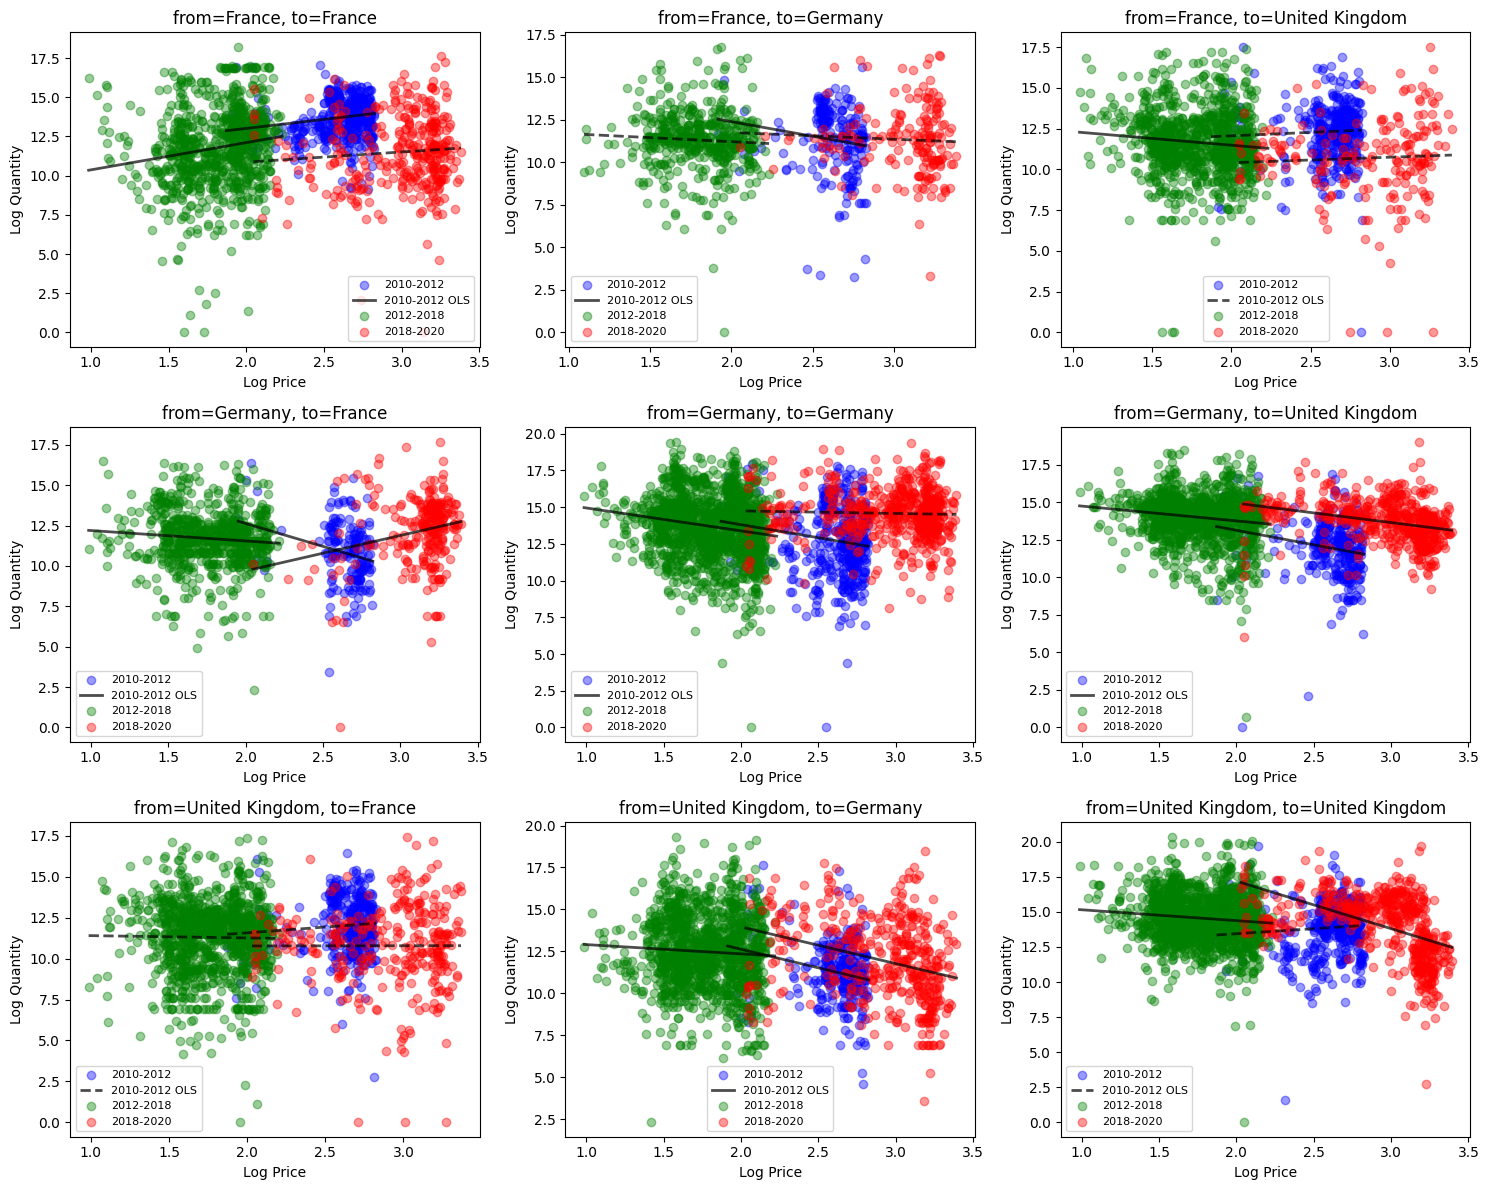

,from,to,period,intercept,intercept_pval,price_slope,price_slope_pval,lad.intercept,lad.intercept_pval,lad.price_slope,lad.price_slope_pval,n_obs
0,France,France,2010-2012,10.7005,0.0000,1.1548,0.0001,8.4220,0.0000,2.0804,0.0000,495
1,France,France,2012-2018,8.6286,0.0000,1.7383,0.0000,7.8711,0.0000,2.2169,0.0000,843
2,France,France,2018-2020,9.5548,0.0000,0.6511,0.1310,8.0848,0.0000,1.0894,0.0580,347
3,France,Germany,2010-2012,15.8374,0.0000,-1.7195,0.0362,15.2989,0.0000,-1.3534,0.1442,214
4,France,Germany,2012-2018,12.1703,0.0000,-0.4747,0.1804,12.3304,0.0000,-0.5334,0.0645,508
5,France,Germany,2018-2020,12.5516,0.0000,-0.3952,0.4958,12.2881,0.0000,-0.3205,0.6255,182
6,France,United Kingdom,2010-2012,11.2287,0.0000,0.4183,0.3923,11.1071,0.0000,0.5512,0.2776,387
7,France,United Kingdom,2012-2018,13.1456,0.0000,-0.8283,0.0023,13.4889,0.0000,-1.0736,0.0002,972
8,France,United Kingdom,2018-2020,9.7319,0.0000,0.3396,0.4904,10.5726,0.0000,0.0754,0.8749,201
9,Germany,France,2010-2012,18.3084,0.0000,-2.8389,0.0007,18.5256,0.0000,-2.8809,0.0087,179


In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Assuming top_data is already defined and processed
top_data = top_data.drop(columns=top_data.filter(like='period_').columns, errors='ignore')
top_data['period'] = pd.to_datetime(top_data['date']).apply(lambda d: '2010-2012' 
                                                            if d <= pd.Timestamp('2011-12-31') 
                                                            else ('2012-2018' if d <= pd.Timestamp('2017-12-31') 
                                                                  else '2018-2020'))

pairs = top_data.groupby(['transferringAccount_registry', 'acquiringAccount_registry'])
n, cols = len(pairs), round(np.sqrt(len(pairs)))
rows = -(-n // cols)
mult =1.5
fig, axes = plt.subplots(rows, cols, figsize=(mult*10, mult*8))
if not isinstance(axes, np.ndarray): 
    axes = np.array([axes])
axes = axes.flatten()

results_list = []

for ax, ((from_, to), subdf) in zip(axes, pairs):
    if len(subdf) < 2: 
        ax.set_visible(False)
        continue
    
    periods = [
        ('2010-2012', subdf['period'] == '2010-2012', 'blue'),
        ('2012-2018', subdf['period'] == '2012-2018', 'green'),
        ('2018-2020', subdf['period'] == '2018-2020', 'red'),
    ]

    ax.set_title(f"from={from_}, to={to}", fontdict={'fontsize': 12})
    ax.set_xlabel("Log Price", fontdict={'fontsize': 10})
    ax.set_ylabel("Log Quantity", fontdict={'fontsize': 10})

    for label, mask, color in periods:
        period_df = subdf.loc[mask].copy()
        if len(period_df) < 2:
            continue
        
        # Remove any inf or nan values after log transformation
        period_df['log_price'] = np.log(period_df['Secondary_Market_price'])
        period_df['log_quantity'] = np.log(period_df['amount'])
        
        # Drop rows with inf or nan
        period_df = period_df.replace([np.inf, -np.inf], np.nan).dropna(subset=['log_price', 'log_quantity'])
        
        if len(period_df) < 2:
            continue
        
        x_vals = period_df['log_price']
        y_vals = period_df['log_quantity']

        # Fit OLS model: y = intercept + slope * x
        X = sm.add_constant(x_vals)
        ols_model = sm.OLS(y_vals, X).fit()
        
        # Fit LAD (Least Absolute Deviation) model - robust to outliers
        lad_model = sm.QuantReg(y_vals, X).fit(q=0.5)  # Median regression (LAD)
        
        # Scatter plot
        ax.scatter(x_vals, y_vals, alpha=0.4, color=color, label=label)

        # Prepare regression lines
        x_line = np.linspace(x_vals.min(), x_vals.max(), 100)
        X_line = sm.add_constant(x_line)
        
        # OLS line
        y_ols = ols_model.predict(X_line)
        ols_line_style = '-' if ols_model.pvalues[1] < 0.05 else '--'
        ax.plot(x_line, y_ols, color='black', linestyle=ols_line_style, 
                linewidth=2, alpha=0.7, label=f'{label} OLS' if label == periods[0][0] else '')

        # Store results
        results_list.append({
            "from": from_,
            "to": to,
            "period": label,
            "intercept": round(ols_model.params[0], 4),
            "intercept_pval": round(ols_model.pvalues[0], 4),
            "price_slope": round(ols_model.params[1], 4),
            "price_slope_pval": round(ols_model.pvalues[1], 4),
            "lad.intercept": round(lad_model.params[0], 4),
            "lad.intercept_pval": round(lad_model.pvalues[0], 4),
            "lad.price_slope": round(lad_model.params[1], 4),
            "lad.price_slope_pval": round(lad_model.pvalues[1], 4),
            "n_obs": len(period_df),
        })

    ax.legend(fontsize=8)

# Hide unused subplots
for i in range(len(pairs), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

# Create results dataframes
results_df = pd.DataFrame(results_list)
results_df

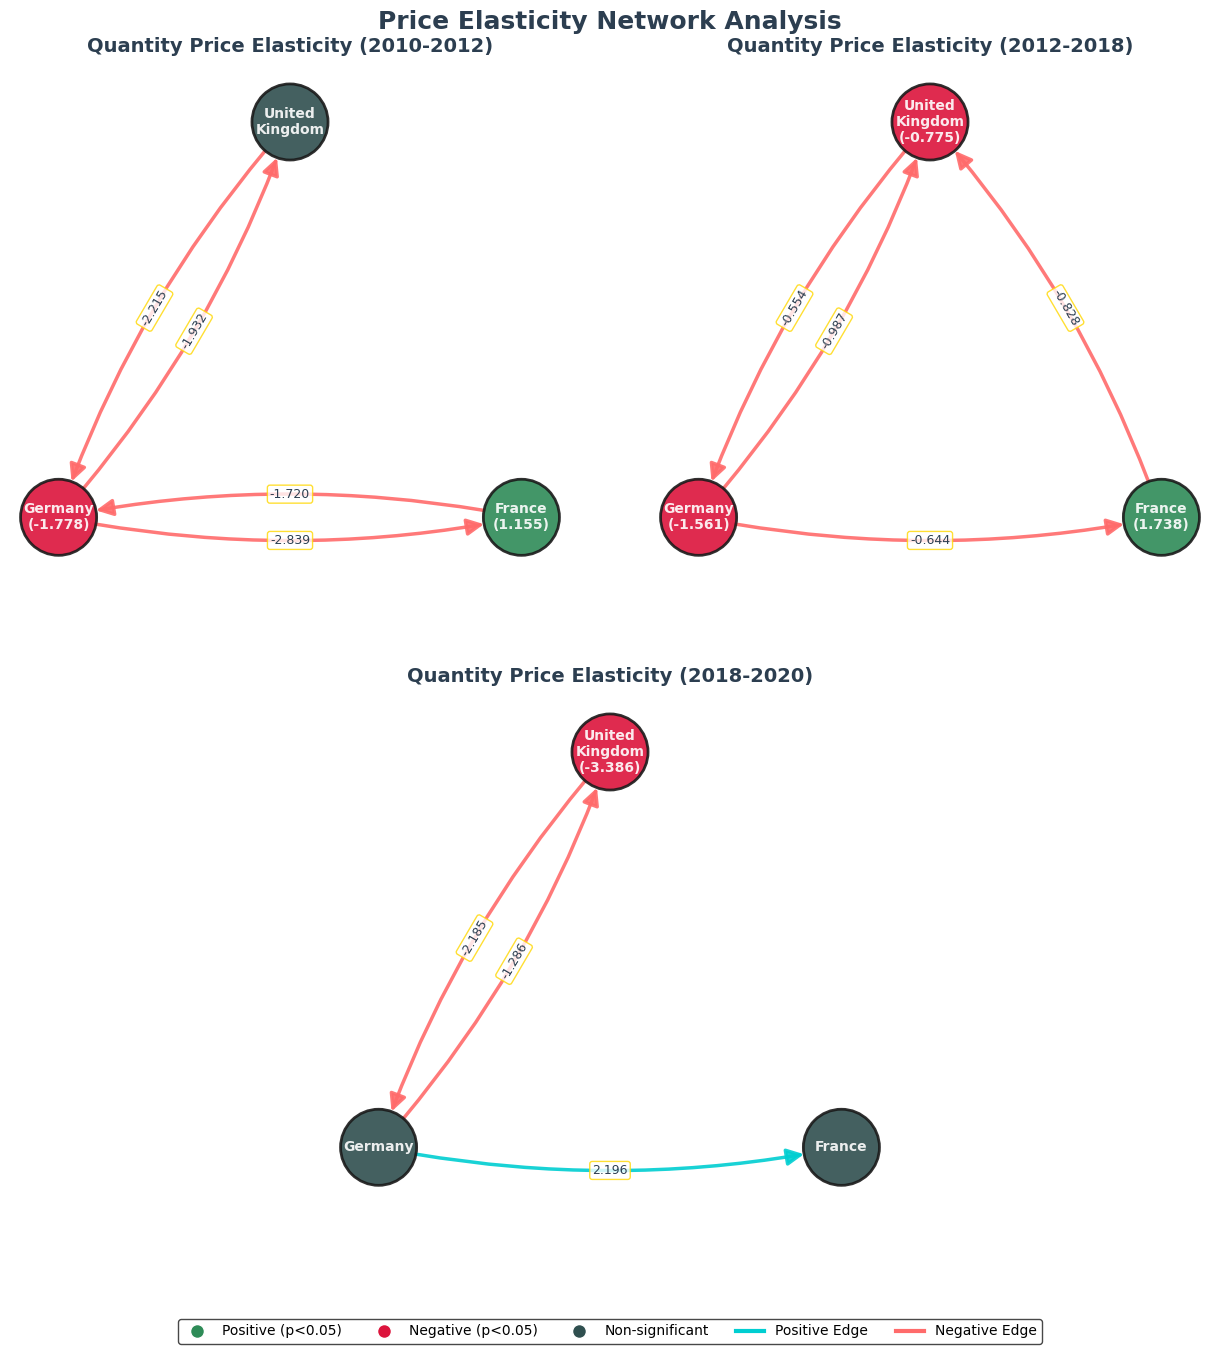

In [18]:
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict
import numpy as np

# Group results by period label
period_groups = defaultdict(list)
for d in results_list:
    period_label = d["period"]  # third element is the period
    period_groups[period_label].append(d)

# Define positions for nodes
pos = {
    "France": (1, -0.5),
    "Germany": (-1, -0.5),
    "United Kingdom": (0, 1)
}

# Prepare subplots
period_names = list(period_groups.keys())
n = len(period_names)

# Create 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Stylish color scheme
COLORS = {
    # Node colors
    'node_positive': '#2E8B57',      # Sea Green - significant positive
    'node_negative': '#DC143C',      # Crimson - significant negative  
    'node_neutral': '#2F4F4F',       # Dark Slate Gray - non-significant
    'node_border': '#1A1A1A',        # Almost Black for node borders
    
    # Edge colors
    'edge_positive': '#00CED1',      # Dark Turquoise - positive edges
    'edge_negative': '#FF6B6B',      # Light Red - negative edges
    'edge_highlight': '#FFD700',     # Gold for edge highlights
    
    # Background and text
    'background': '#F8F8FF',         # Ghost White
    'text_dark': '#2C3E50',          # Dark Blue Gray
    'text_light': 'white'
}

# Flatten axes for easier iteration but keep 2D structure for positioning
axes_flat = axes.flatten()

# Set figure background color
fig.patch.set_facecolor(COLORS['background'])

# Draw each period's graph
for idx, period_name in enumerate(period_names):
    if idx < 4:  # Safety check
        period_data = period_groups[period_name]
        G = nx.DiGraph()
        countries = {"France": {}, "Germany": {}, "United Kingdom": {}}

        # Process nodes
        for d in period_data:
            src, dst, label = d['from'], d['to'], d["period"]
            price_slope = d["price_slope"]
            pval = d["price_slope_pval"]

            if src == dst:
                if pval < 0.05:
                    countries[src]["color"] = COLORS['node_positive'] if price_slope > 0 else COLORS['node_negative']
                    countries[src]["label"] = f"{src}\n({price_slope:.3f})"
                else:
                    countries[src]["color"] = COLORS['node_neutral']
                    countries[src]["label"] = src

        # Process edges
        for d in period_data:
            src, dst, label =  d['from'], d['to'], d["period"]
            price_slope = d["price_slope"]
            pval = d["price_slope_pval"]

            if src != dst and pval < 0.05:
                color = COLORS['edge_positive'] if price_slope > 0 else COLORS['edge_negative']
                G.add_edge(src, dst, color=color, weight=abs(price_slope), label=f"{price_slope:.3f}")

        # Add nodes
        for c, attrs in countries.items():
            if c == "United Kingdom":
                label = attrs.get("label",c).replace('United Kingdom','United\nKingdom')
                G.add_node(c, color=attrs.get("color", COLORS['node_neutral']), label=label)
            else:
                G.add_node(c, color=attrs.get("color", COLORS['node_neutral']), label=attrs.get("label", c))

        # Draw graph
        ax = axes_flat[idx]
        
        # Set subplot background and style
        ax.set_facecolor(COLORS['background'])
        ax.set_title(f"Quantity Price Elasticity ({period_name})", 
                    fontsize=14, fontweight='bold', color=COLORS['text_dark'], pad=20)
        
        node_colors = [G.nodes[n].get("color", COLORS['node_neutral']) for n in G.nodes()]
        labels = {n: G.nodes[n].get("label", n) for n in G.nodes()}
        edge_colors = [G[u][v]["color"] for u, v in G.edges()]
        edge_labels = nx.get_edge_attributes(G, "label")

        # Draw with stylish parameters
        nx.draw(G, pos, ax=ax, with_labels=True, labels=labels, node_color=node_colors,
                node_size=3000, font_size=10, font_color=COLORS['text_light'], font_weight='bold',
                edge_color=edge_colors, arrowsize=25, width=2.5, connectionstyle='arc3,rad=0.1',
                node_shape='o', alpha=0.9, linewidths=2, edgecolors=COLORS['node_border'])
        
        # Draw edge labels with better styling
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9, ax=ax, 
                                   connectionstyle='arc3,rad=0.1', font_color=COLORS['text_dark'],
                                   bbox=dict(boxstyle='round,pad=0.2', facecolor='white', 
                                           alpha=0.8, edgecolor=COLORS['edge_highlight']))

# Hide unused subplots and center the third one if needed
for i in range(len(period_names), 4):
    axes_flat[i].set_facecolor(COLORS['background'])
    axes_flat[i].axis('off')

# If we have exactly 3 subplots, remove the 4th one completely and adjust layout
if n == 3:
    # Remove the 4th subplot
    fig.delaxes(axes_flat[3])
    
    # Adjust layout to center the three subplots
    plt.tight_layout()
    
    # Manual adjustment to center the three subplots in 2x2 grid
    # First subplot: top-left position
    axes_flat[0].set_position([0.125, 0.55, 0.35, 0.35])
    # Second subplot: top-right position  
    axes_flat[1].set_position([0.525, 0.55, 0.35, 0.35])
    # Third subplot: bottom-center position
    axes_flat[2].set_position([0.325, 0.1, 0.35, 0.35])
else:
    plt.tight_layout()

# Add a nice super title
plt.suptitle("Price Elasticity Network Analysis", fontsize=18, fontweight='bold', 
             color=COLORS['text_dark'], y=0.95)

# Add a legend for colors
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=COLORS['node_positive'], 
               markersize=10, label='Positive (p<0.05)'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=COLORS['node_negative'], 
               markersize=10, label='Negative (p<0.05)'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=COLORS['node_neutral'], 
               markersize=10, label='Non-significant'),
    plt.Line2D([0], [0], color=COLORS['edge_positive'], lw=3, label='Positive Edge'),
    plt.Line2D([0], [0], color=COLORS['edge_negative'], lw=3, label='Negative Edge')
]

fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.02),
           ncol=5, frameon=True, facecolor='white', edgecolor=COLORS['node_border'],
           fontsize=10)

plt.show()

## Descriptive market overview


In [1]:
import pandas as pd
data = pd.read_csv('Data handling/OHA_PHA_price.csv')
data.shape

(549686, 18)

In [2]:
data['date'] = pd.to_datetime(data['date'])
data = data.drop(columns=data.columns[0])
data.head()

,transactionID,date,transactionTypeMain_id,transactionTypeSupplementary_id,transferringAccount_id,acquiringAccount_id,unitType_id,tradingSystem_id,amount,transferringAccount_registry_id,transferringAccount_type_id,acquiringAccount_registry_id,acquiringAccount_type_id,acquiringAccount_type,transferringAccount_type,Primary_Market_price,Secondary_Market_price
0,DE86046,2010-01-05,10.0,0.0,63347.0,64365.0,EUA_2008,euets,125312.0,DE,121-0,DE,121-0,Person Account in National Registry,Person Account in National Registry,12.67,12.55
1,DK537189,2010-01-05,10.0,0.0,74412.0,65239.0,EUA_2008,euets,4000.0,DK,121-0,DK,121-0,Person Account in National Registry,Person Account in National Registry,12.67,12.55
2,FR136450,2010-01-05,10.0,0.0,26016.0,6909.0,EUA_2008,euets,11000.0,FR,121-0,FR,121-0,Person Account in National Registry,Person Account in National Registry,12.67,12.55
3,DE86045,2010-01-05,10.0,0.0,64286.0,64829.0,EUA_2008,euets,1000.0,DE,121-0,DE,121-0,Person Account in National Registry,Person Account in National Registry,12.67,12.55
4,DE86067,2010-01-05,10.0,0.0,64286.0,64829.0,EUA_2008,euets,17479.0,DE,121-0,DE,121-0,Person Account in National Registry,Person Account in National Registry,12.67,12.55


In [3]:
sum(pd.isna(data['Secondary_Market_price']))

0

In [4]:
import numpy as np
data['transferringAccount_type'] = np.where(data['transferringAccount_type_id'].isin(["100-8","100-12","121-0"]), 'PHA', 'OHA')
data['acquiringAccount_type'] = np.where(data['acquiringAccount_type_id'].isin(["100-8","100-12","121-0"]), 'PHA', 'OHA')
data.head()

,transactionID,date,transactionTypeMain_id,transactionTypeSupplementary_id,transferringAccount_id,acquiringAccount_id,unitType_id,tradingSystem_id,amount,transferringAccount_registry_id,transferringAccount_type_id,acquiringAccount_registry_id,acquiringAccount_type_id,acquiringAccount_type,transferringAccount_type,Primary_Market_price,Secondary_Market_price
0,DE86046,2010-01-05,10.0,0.0,63347.0,64365.0,EUA_2008,euets,125312.0,DE,121-0,DE,121-0,PHA,PHA,12.67,12.55
1,DK537189,2010-01-05,10.0,0.0,74412.0,65239.0,EUA_2008,euets,4000.0,DK,121-0,DK,121-0,PHA,PHA,12.67,12.55
2,FR136450,2010-01-05,10.0,0.0,26016.0,6909.0,EUA_2008,euets,11000.0,FR,121-0,FR,121-0,PHA,PHA,12.67,12.55
3,DE86045,2010-01-05,10.0,0.0,64286.0,64829.0,EUA_2008,euets,1000.0,DE,121-0,DE,121-0,PHA,PHA,12.67,12.55
4,DE86067,2010-01-05,10.0,0.0,64286.0,64829.0,EUA_2008,euets,17479.0,DE,121-0,DE,121-0,PHA,PHA,12.67,12.55


In [5]:
data['value'] = data['amount']*data['Secondary_Market_price']

In [6]:
data.head()

,transactionID,date,transactionTypeMain_id,transactionTypeSupplementary_id,transferringAccount_id,acquiringAccount_id,unitType_id,tradingSystem_id,amount,transferringAccount_registry_id,transferringAccount_type_id,acquiringAccount_registry_id,acquiringAccount_type_id,acquiringAccount_type,transferringAccount_type,Primary_Market_price,Secondary_Market_price,value
0,DE86046,2010-01-05,10.0,0.0,63347.0,64365.0,EUA_2008,euets,125312.0,DE,121-0,DE,121-0,PHA,PHA,12.67,12.55,1572665.60
1,DK537189,2010-01-05,10.0,0.0,74412.0,65239.0,EUA_2008,euets,4000.0,DK,121-0,DK,121-0,PHA,PHA,12.67,12.55,50200.00
2,FR136450,2010-01-05,10.0,0.0,26016.0,6909.0,EUA_2008,euets,11000.0,FR,121-0,FR,121-0,PHA,PHA,12.67,12.55,138050.00
3,DE86045,2010-01-05,10.0,0.0,64286.0,64829.0,EUA_2008,euets,1000.0,DE,121-0,DE,121-0,PHA,PHA,12.67,12.55,12550.00
4,DE86067,2010-01-05,10.0,0.0,64286.0,64829.0,EUA_2008,euets,17479.0,DE,121-0,DE,121-0,PHA,PHA,12.67,12.55,219361.45


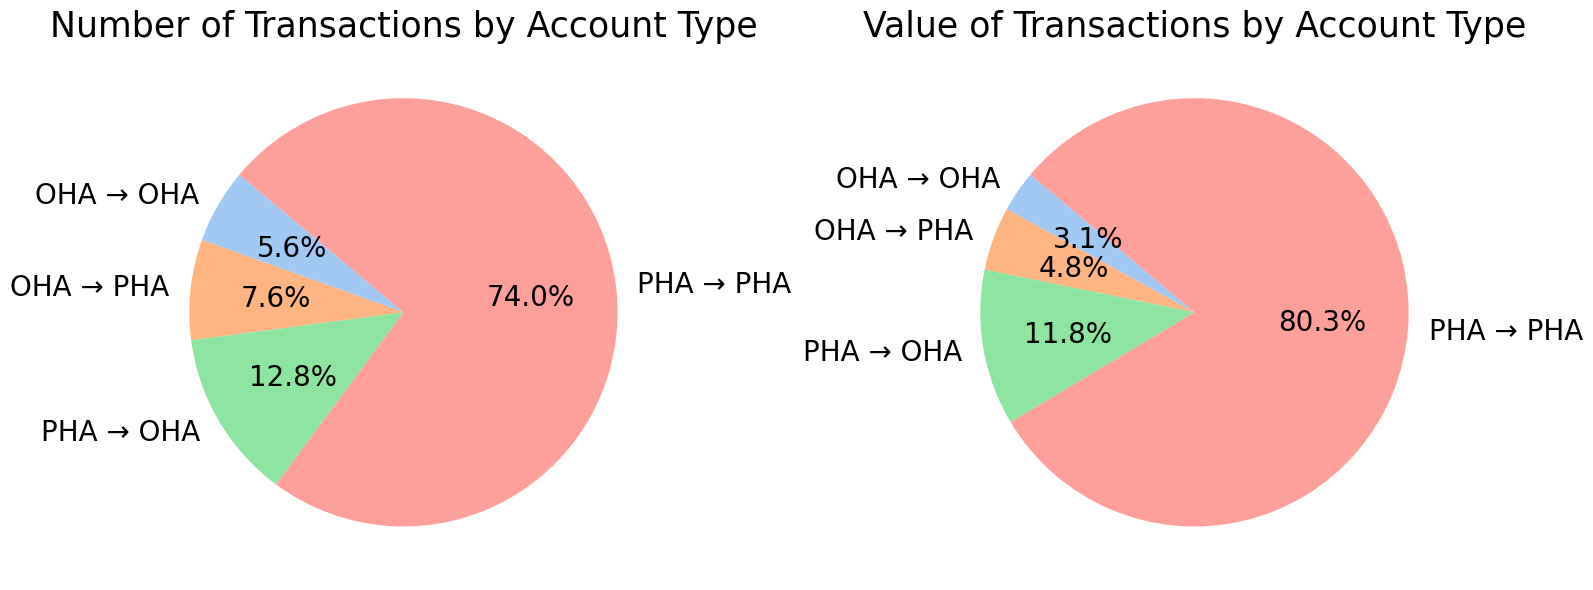

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare counts
count_number = data[['transferringAccount_type','acquiringAccount_type']].value_counts()
count_value = data.groupby(['transferringAccount_type','acquiringAccount_type']).agg({'value':'sum'})

# Sort both by index to make sure ordering is consistent
count_number = count_number.sort_index()
count_value = count_value.sort_index()

# Convert MultiIndex to string labels
labels = [f"{i[0]} → {i[1]}" for i in count_number.index]

# Choose a seaborn color palette
colors = sns.color_palette("pastel", len(labels))

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 9))

# Pie chart 1: Number of transactions
axes[0].pie(count_number, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors,
            textprops={'fontsize': 20})
axes[0].set_title('Number of Transactions by Account Type', fontsize=25)

# Pie chart 2: Value of transactions
axes[1].pie(count_value['value'], labels=labels, autopct='%1.1f%%', startangle=140, colors=colors,
            textprops={'fontsize': 20})
axes[1].set_title('Value of Transactions by Account Type', fontsize=25)

plt.tight_layout()
plt.show()


In [8]:
# ---------- Bar Plot Data ----------
# Combine OHA accounts (from both transferring and acquiring)
oha_ids = pd.unique(
    pd.concat([
        data.loc[data['transferringAccount_type'] == 'OHA', 'transferringAccount_id'],
        data.loc[data['acquiringAccount_type'] == 'OHA', 'acquiringAccount_id']
    ], ignore_index=True)
)
oha_ids = oha_ids[~pd.isna(oha_ids)]

# Combine PHA accounts (from both transferring and acquiring)
pha_ids = pd.unique(
    pd.concat([
        data.loc[data['transferringAccount_type'] == 'PHA', 'transferringAccount_id'],
        data.loc[data['acquiringAccount_type'] == 'PHA', 'acquiringAccount_id']
    ], ignore_index=True)
)
pha_ids = pha_ids[~pd.isna(pha_ids)]

# Create summary DataFrame
summary = pd.DataFrame({
    'Account_Type': ['OHA', 'PHA'],
    'Unique_Accounts': [len(oha_ids), len(pha_ids)]
})
oha_ids

array([ 13938.,  10026.,  10002., ...,  98362., 116681., 113356.])

C:\Users\chakr\AppData\Local\Temp\ipykernel_16456\3783203029.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Account_Type', y='Unique_Accounts', data=summary, palette=colors_bar, width=0.5, ax=axes[0])


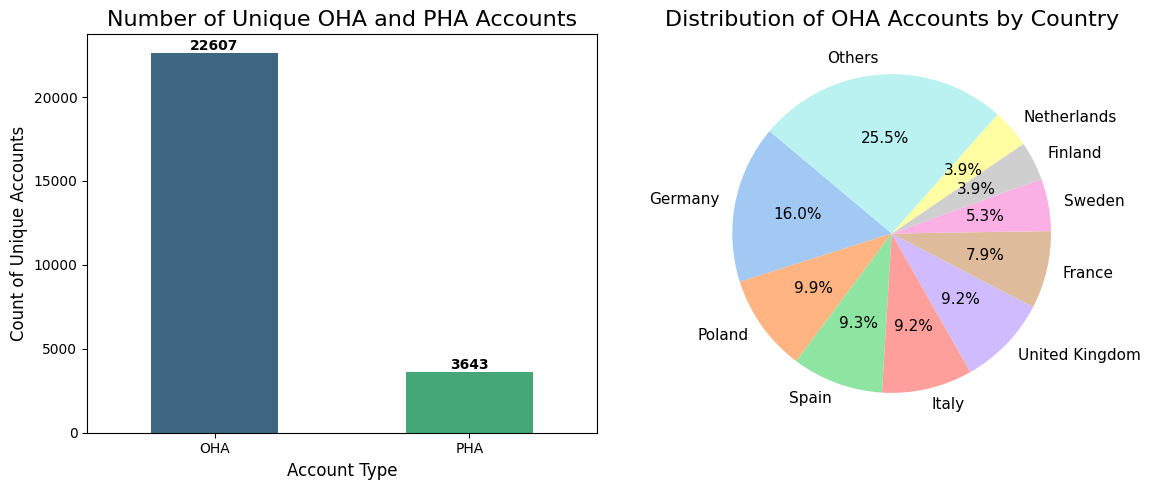

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# ---------- Pie Chart Data ----------
country_specific = pd.concat([
    data.loc[data['transferringAccount_type'] == 'OHA', 'transferringAccount_registry'],
    data.loc[data['acquiringAccount_type'] == 'OHA', 'acquiringAccount_registry']
]).value_counts()

country_percent = (country_specific * 100 / country_specific.sum()).sort_values(ascending=False)
country_cumsum = country_percent.cumsum()

# Group beyond 75% into "Others"
main_countries = country_percent[country_cumsum <= 76]
others_percent = country_percent[country_cumsum > 76].sum()
final_percent = pd.concat([main_countries, pd.Series({'Others': others_percent})])

# ---------- Combined Subplots ----------
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- Bar Plot (Left) ---
colors_bar = sns.color_palette("viridis", n_colors=2)
sns.barplot(x='Account_Type', y='Unique_Accounts', data=summary, palette=colors_bar, width=0.5, ax=axes[0])

axes[0].set_title('Number of Unique OHA and PHA Accounts', fontsize=16)
axes[0].set_xlabel('Account Type', fontsize=12)
axes[0].set_ylabel('Count of Unique Accounts', fontsize=12)
axes[0].tick_params(labelsize=10)

# Annotate bars
for i, row in summary.iterrows():
    axes[0].text(i, row['Unique_Accounts'] + 0.5, str(row['Unique_Accounts']),
                 ha='center', va='bottom', fontsize=10, fontweight='bold')

# --- Pie Chart (Right) ---
colors_pie = sns.color_palette("pastel", len(final_percent))
axes[1].pie(final_percent, labels=final_percent.index, autopct='%1.1f%%', startangle=140,
            colors=colors_pie, textprops={'fontsize': 11})
axes[1].set_title('Distribution of OHA Accounts by Country', fontsize=16)

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

df = pd.read_csv('Data handling/account.csv')

oha = df[~df['installation_id'].isna()]
sum(~oha['openingDate'].isna())
oha['closingDate'] = pd.to_datetime(oha['closingDate'],format = 'mixed')
oha['openingDate'] = pd.to_datetime(oha['openingDate'],format = 'mixed')
oha = oha[((oha['closingDate']>'2010-01-01')|(oha['closingDate'].isna()))&(oha['openingDate']<'2020-04-20')]
22607/oha.shape[0]

C:\Users\chakr\AppData\Local\Temp\ipykernel_19908\2147804265.py:4: DtypeWarning: Columns (4,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Data handling/account.csv')
C:\Users\chakr\AppData\Local\Temp\ipykernel_19908\2147804265.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oha['closingDate'] = pd.to_datetime(oha['closingDate'],format = 'mixed')
C:\Users\chakr\AppData\Local\Temp\ipykernel_19908\2147804265.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

0.8023779946761314